# Visualization of a Simple Stochastic Gradient Descent

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla GD, batch SGD and minibatch SGD. For this we consider a linear model with only two weights (the slope and the offset).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.version.VERSION

'2.3.0'

## Dataset
Let's create the dataset. We generate a random vector $x \in [-0.5, 0.5]$ and evaluate it in a linear function $y = 2x$. We add some noise to $y$ and that give us $y \in [-1.5, 1.5]$.

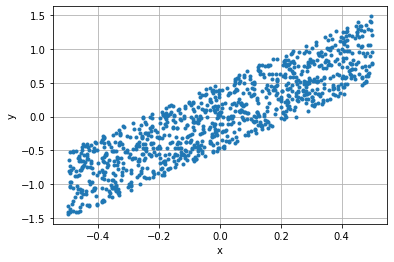

In [3]:
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Input pipeline

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
dataset = dataset.shuffle(1000)  # shuffle by chunks of 1000 samples. In this case, that's the how dataset.
dataset = dataset.batch(100)     # set the batch size
dataset = dataset.repeat(150)    # set the number of epocs

## Defining the model and choosing an optimizer

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,), activation='linear'),
])

opt = tf.keras.optimizers.SGD(lr=0.5)

model.compile(optimizer=opt,
              loss='mse')

### Use a callback to store the training history
This is not really part of the training. We store the SGD trajectory for plotting later. What this does, is to append the current values of the wights and the loss after every batch.

In [8]:
class TrainHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.vars = []
        self.loss = []

    def on_batch_end(self, batch, logs={}):
        self.vars.append([v.numpy() for v in self.model.variables])
        self.loss.append(logs.get('loss'))


history = TrainHistory()

## Training

In [9]:
fit = model.fit(dataset, callbacks=[history])

1500/1500 [==============================] - 2s 1ms/step - loss: 0.0862


## Plots

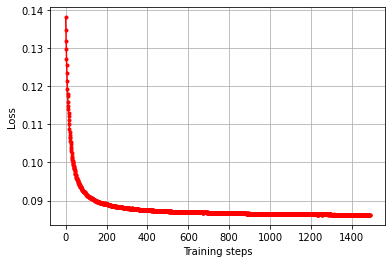

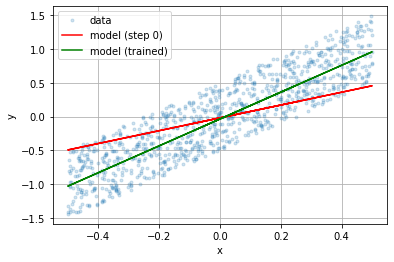

In [11]:
slope_hist = np.array(history.vars)[:, 0]
offset_hist = np.array(history.vars)[:, 1]
loss_hist = np.array(history.loss)

plt.plot(loss_hist[10:], 'r.-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(x_train, y_train, '.', label='data', alpha=0.2)
plt.plot(x_train, slope_hist[0] * x_train + offset_hist[0], 'r-', label='model (step 0)')
plt.plot(x_train, slope_hist[-1] * x_train + offset_hist[-1], 'g-', label='model (trained)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

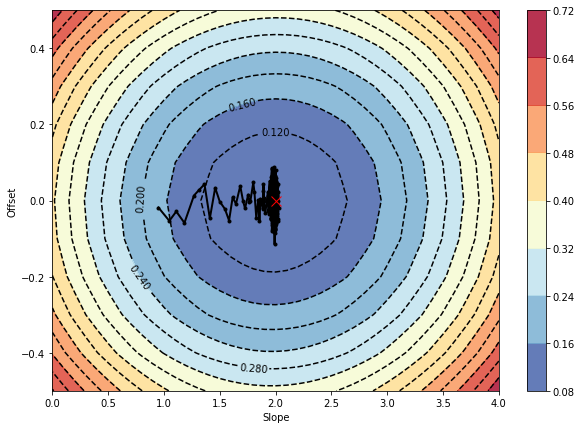

In [12]:
def loss_function_field(m, n, xref, yref):
    '''Utility function for ploting the loss'''
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange(-0, 4.01, 0.1)
_n = np.arange(-0.5, 0.51, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_train, y_train)

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

cp = plt.contour(M, N, Z, 15, vmin=Z.min(), vmax=Z.max(), alpha=0.99, colors='k', linestyles='--')
plt.contourf(M, N, Z, vmin=Z.min(), vmax=Z.max(), alpha=0.8, cmap=plt.cm.RdYlBu_r)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot(slope_hist, offset_hist, '.-', lw=2, c='k')
plt.plot([ref_slope], [ref_offset], 'rx', ms=10)
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

<mark>Exercise 1</mark>: Try different batch sizes:
 * `batch_size = 1000` (The whole dataset)
 * `batch_size = 100` (Something between 1 and the size of whole dataset.)
 * `batch_size = 1`

1. Check the SGD trajectories. Why are they different?
2. The case `batch_size = 1` is quite slow compared to `batch_size = 100` and `batch_size = 1000`. Why?